In [1]:
from bert_embedding import BertEmbedding
  
import numpy as np 
import pandas as pd
  
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
CITY = 'sydney'

In [20]:
def zomatoPreprocess(city,cuisines=True):

    zomato = pd.read_csv(city+'.csv')
    
    if cuisines:
        
        zomato = zomato[['name','url','cuisines']].dropna(axis=0)

        sentences = zomato.cuisines.apply(lambda x:x.replace('[','')
                                                    .replace(']','')
                                                    .replace('"','')
                                                    .replace(',',' ')
                                                    .replace('and','') + ' food'
                                                    .replace('  ',' ')).values
    else:
        
        zomato = zomato[['name','url','food_items']].dropna(axis=0)
    
        food = zomato.food_items.apply(lambda x:[food.rstrip() 
                                             for food 
                                             in (str(x).replace('\\n','').split(','))])
        new_f = ''
        new_food = []
        for f in food:
            for i in range(len(f)):
                if i == len(f)-1: new_f += f[i]
                else: new_f += f[i]+'. '
            new_food += [new_f]
            new_f = ''
            
        sentences = new_food

    names = zomato.name.values
    urls = zomato.url.apply(lambda x:x.replace('\n','')).values
    
    return sentences, urls, names

In [21]:
c, u, n = zomatoPreprocess(CITY)
c

array(['Coffee  Tea Cafe Food food',
       'Desserts Cafe Food Coffee  Tea food', 'Others food', ...,
       'Fast Food Burger food', 'Fast Food Burger food', 'Others food'],
      dtype=object)

# BERT: Bidirectional Encoder Representations from Transformers

#### Abstract:

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT representations can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE benchmark to 80.4% (7.6% absolute improvement), MultiNLI accuracy to 86.7 (5.6% absolute improvement) and the SQuAD v1.1 question answering Test F1 to 93.2 (1.5% absolute improvement), outperforming human performance by 2.0%.

.

###### This notebook uses the bert-embeddings pypi package which builds off of gluon-nlp https://pypi.org/project/bert-embedding/

.

In [22]:
def stack(embeddings,stacked=[],n=0):

    if len(stacked)>0: x = stacked
    else: x = embeddings[0]
    
    try:stacked = np.add(np.array(x), embeddings[1])
    except:return np.array(x)
    
    n += 1
    
    return stack(embeddings[1:],stacked=stacked,n=n)



def __bagofBERTs(restaurants,urls,berts):
    
    output = []
    x = list(zip(restaurants,urls))
    for (restaurant,url),(cuisines,embeddings) in zip(x,berts):
        embedding = stack(embeddings)
        output += [(restaurant,url,cuisines,embedding)]
        
    return output



def getEmbeddings(n_restaurants=None,city=CITY,cuisines=True):
    
    print('Cleaning Zomato data for {}.\n'.format(city))
    cuisines, urls, names = zomatoPreprocess(CITY.lower(),cuisines=cuisines)
    
    if n_restaurants == None: n_restaurants = len(cuisines)
    
    print('Retrieving BERT sentence representations for {} restuarants...\n'.format(n_restaurants))
    __bert_embedding = BertEmbedding(model='bert_12_768_12')
    __berts = __bert_embedding(cuisines[:n_restaurants])
    bagofembeddings = __bagofBERTs(names, urls, __berts)
    
    print('Complete.')
    
    filtrd = [(n,u,c,e) for n,u,c,e
              in bagofembeddings 
                  if len(e.shape)>0]

    cuisines = [c for n,u,c,e in filtrd]
    embeds = [e for n,u,c,e in filtrd]
    names = [n for n,u,c,e in filtrd]
    urls = [u for n,u,c,e in filtrd]
    
    return names,cuisines,urls,embeds,bagofembeddings
    

In [23]:
names, cuisines, urls, embeds, bag = getEmbeddings(n_restaurants=100,cuisines=False)

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 100 restuarants...

Complete.


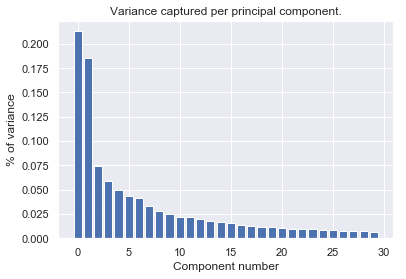

In [25]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

summed = sum(pca.explained_variance_)

plt.bar(range(len(pca.explained_variance_)),[i/summed for i in (pca.explained_variance_)])
plt.title('Variance captured per principal component.')
plt.ylabel('% of variance')
plt.xlabel('Component number')
plt.show()

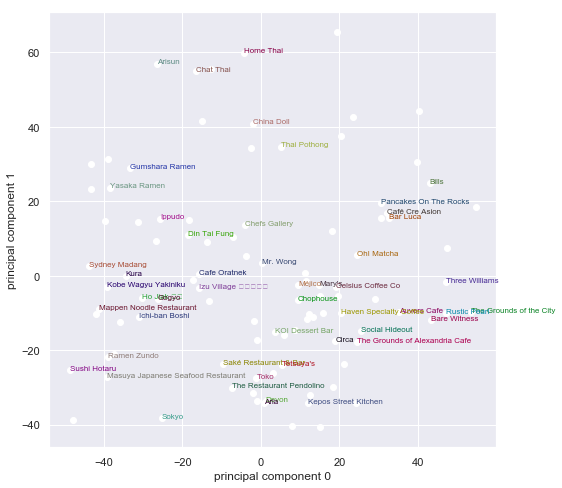

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca1,c='white')
for i, x, y in zip(names, pca0[:50], pca1[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 1')
plt.show()

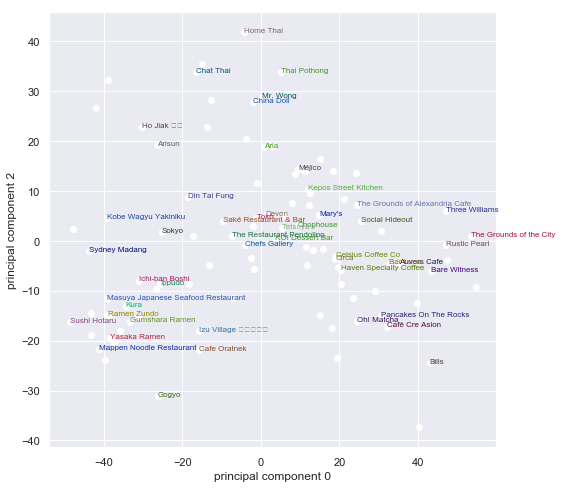

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(pca0,pca2,c='white')
for i, x, y in zip(names, pca0[:50], pca2[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.xlabel('principal component 0')
plt.ylabel('principal component 2')
plt.show()

In [28]:
from scipy.spatial.distance import cosine, euclidean

Cosine similarity for nearest neighbours search:
$$similarity = cos(\theta) = \frac{A \cdot B}{||A||\,||B||} = \frac{\sum_{i=1}^nA_iB_i}{\sqrt{\sum_{i=1}^nA_i^2} {\sqrt{\sum_{i=1}^nB_i^2}}}$$

In [29]:
def nearest_neighbours(embeddings,from_index=None,from_name=None,names=names,to_df=True,cos=True):
    
    if from_index==None and from_name!=None: from_index = names.index(from_name)
        
    from_emb = embeddings[from_index]
    from_name = names[from_index] if from_name==None else from_name
    
    if cosine: dist = lambda x: cosine(from_emb,x)
    else: dist = lambda x: euclidean(from_emb,x)
    
    nn = sorted([(to_name,dist(to_emb)) 
                     for to_emb,to_name 
                         in zip(embeddings,names)]
                
                ,key=lambda x:x[1]
                ,reverse=False)
    
    if to_df: nn = pd.DataFrame(nn,columns=['name','distance']).drop_duplicates()
    
    return from_name,nn

In [30]:
restaurant, nn = nearest_neighbours(embeds,3)
print('Restaurants most similar to:',restaurant,'\n')
nn.head(20)

Restaurants most similar to: Ho Jiak 好吃 



,name,distance
0,Ho Jiak 好吃,0.000000
1,Juan Bowl & Tea,0.073208
2,Marigold,0.073277
3,Temasek,0.074447
4,Kobe Wagyu Yakiniku,0.079202
5,Golden Century Seafood,0.081998
6,Mamak,0.083559
7,Din Tai Fung,0.085628
8,Ichi-ban Boshi,0.087906
9,Mr. Wong,0.090422


In [31]:
df = pd.DataFrame(embeds,columns=['emb'+str(n) for n in range(len(embeds[0]))])
df['name'] = names
df['cuisines'] = cuisines

In [32]:
df.to_csv('bert_embeddings.csv')

#### Plotting helpers

In [33]:
##### Graph for dist of merchants across labels

def plot_label_dist(cluster,palette='inferno',figsize=(10,5),flip_axes=False):
    labels = sorted(cluster.labels_.astype(float))
    Y = [labels.count(x) for x in set(labels)]
    X = list(set(labels))
    
    plt.figure(figsize=figsize)
    if flip_axes: sns.barplot(Y,X,palette=palette)
    else: sns.barplot(X,Y,palette=palette)
    plt.xlabel('Cluster label')
    plt.ylabel('# of member restaurants')

    plt.title('distribution across {} clusters'.format(len(set(labels))))
    plt.show()

In [34]:
##### Graph for coloured scatterplot

def plot_clusters(cluster
                  ,pc=principal_components
                  ,text=False
                  ,n_names=10
                  ,centroids=False
                  ,figsize=(6,6)
                  ,multiple_plots=False
                  ,labels=[]
                  ,title=''):
    sns.set()
    pca0 = pc[:,0]
    pca1 = pc[:,1]
    pca2 = pc[:,2]
    
    if len(labels)==0:
        labels = cluster.labels_
    
    if centroids: centroid_plot = cluster.cluster_centers_
    n = 2 if multiple_plots else 1
    
    for i,other_pc in enumerate([pca1,pca2][:n]):
        count=0
        
        plt.figure(figsize=figsize)
        plt.scatter(x=pca0,y=other_pc
                    ,c=labels.astype(float)
                    , s=50
                    , alpha=0.5)
        if centroids: plt.scatter(centroid_plot[:,0], centroid_plot[:,1], c='blue', s=50)
        
        # Add merchant name annontations
        if text:
            for n, (j, x, y) in enumerate(zip(names, pca0, other_pc)):
                if count>n_names: break
                if np.random.rand(1)[0]>0.8:
                    count+=1
                    
                    xytexts = [+3,-3,+5,-5,+7,-7]
                    xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                    plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                        arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

        plt.title('{}'.format(title))
        plt.show()

In [35]:
##### plot for 3d scatterplot, colour coded by label

def plot_3d_clusters(clusters
                     ,text=False
                     ,n_names=8
                     ,pc=principal_components
                     ,figsize=(6,6)):
    
    from mpl_toolkits.mplot3d import Axes3D
    np.random.seed(5)

    X = pc[:,0]
    Y = pc[:,1]
    Z = pc[:,2]

    fignum = 1

    for name,est in clusters:
        count=0
        fig = plt.figure(fignum, figsize=figsize)
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        ax.scatter(X, Y, Z,
                   c=est.labels_.astype(float), edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel('component0')
        ax.set_ylabel('component1')
        ax.set_zlabel('component2')
        ax.set_title(name)
        ax.dist = 12
        fignum = fignum + 1
        
    if text:
        for n, (j, x, y, z) in enumerate(zip(names, X,Y,Z)):
            if count>n_names: break
            if np.random.rand(1)[0]>0.5:
                count+=1

                xytexts = [+3,-3,+5,-5,+7,-7]
                xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                    arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

    fig.show()    


# Comparison of clustering algorithms

#### Kmeans++

In [36]:
kplus = KMeans(n_clusters=12,init='k-means++').fit(embeds)
plot_clusters(kplus,text=True,n_names=15,figsize=(16,4))
plot_label_dist(kplus,palette='Blues',figsize=(4,2))
plot_3d_clusters([('Kmeans++',kplus)],figsize=(6,4.5))

NameError: name 'KMeans' is not defined

#### Affinity Propagation

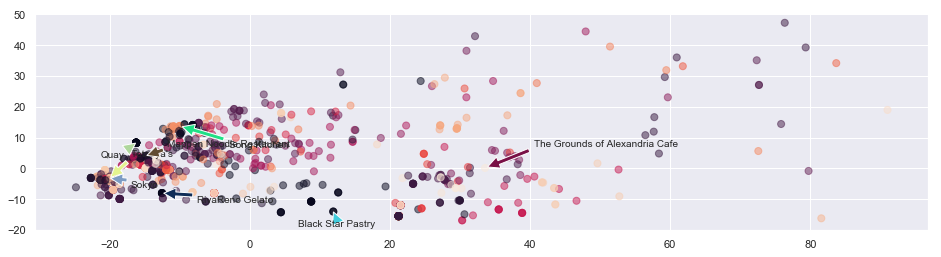

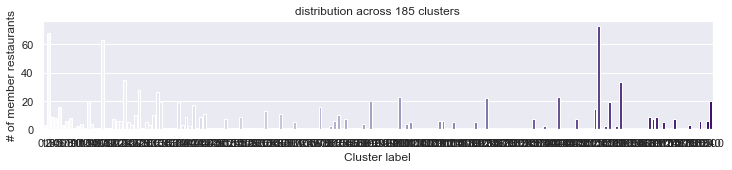

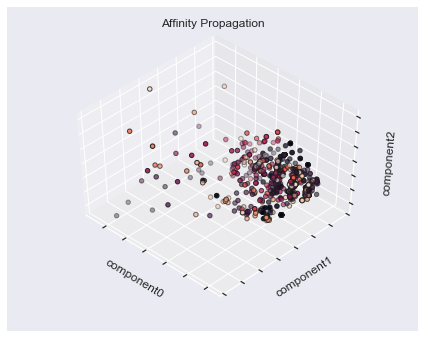

In [235]:
affiProp = AffinityPropagation().fit(embeds)
plot_clusters(affiProp,text=True,n_names=7,figsize=(16,4))
plot_label_dist(affiProp,palette='Purples',figsize=(12,2),flip_axes=False)
plot_3d_clusters([('Affinity Propagation',affiProp)],figsize=(6,4.5))

#### Agglomerative (hierarchical) clustering 

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [238]:
def minimal_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    city = kwargs["city"]
    del kwargs["city"]
    
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram for {}'.format(city))
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [66]:
l = linkage(embeds, method='complete', metric='seuclidean')

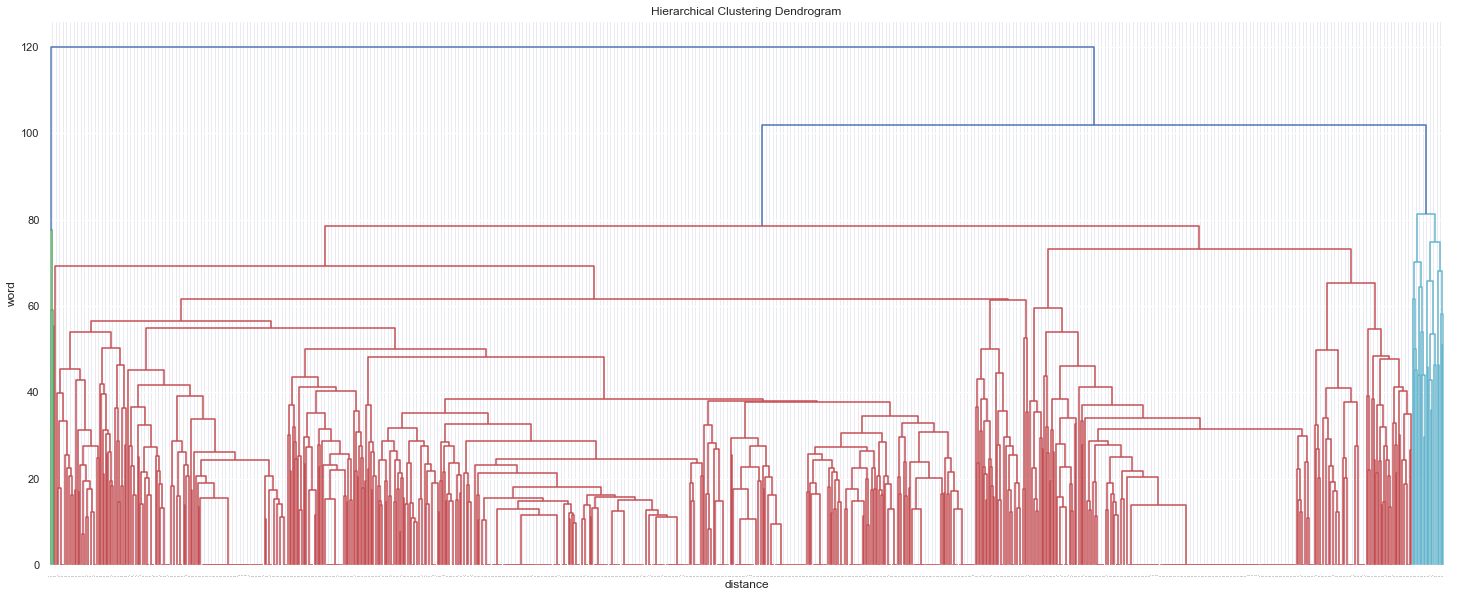

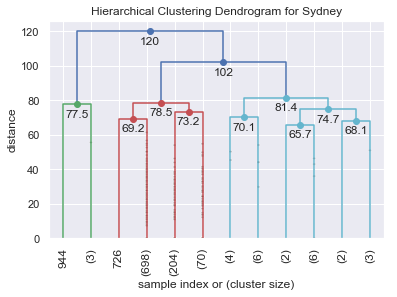

In [239]:
# calculate full dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=0.,  # font size for the x axis labels
    orientation='top',
)
plt.show()

minimal_dendrogram(
    l,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    city='Sydney'
)
plt.show()

#### Copheretic correlation

A statistic that measures how well the denodogram preserves pairwise relations between datapoints. Above 0.8 is a useful baseline.

For embeddings modelled with an hierarichal cluster method to produce a dendrogram $$X_i \longrightarrow T_i$$

we define the following distance measures for the ith and jth observations:

$$Euclid.dist\;=\; x(i, j)\; =\; | X_i − X_j |$$
$$Dendrog.dist\;=\;t(i, j)\; = var(min(C(i,j)))$$

where *t(i,j)* is the item-wise variance of the lowest cluster (via Ward's metric) that *i and j* co-inhabit.

Then, letting $$\bar{x} = \frac{\sum_{i=1}^nx(i, j)}{n}$$$$\bar{t} = \frac{\sum_{i=1}^nt(i,j)}{n}$$

the cophenetic correlation is equal to:

$$c = \frac{\sum_{i<j}(x(i,j)-\bar{x})(t(t,j)-\bar{t})}{\sqrt{[\sum_{i<j}(x(i,j)-\bar{x})^2][\sum_{i<j}(t(i,j)-\bar{t})^2]}}$$

.

###### As c approaches 1, the pairwise preservation improves.

In [201]:
corr, coph_dists = cophenet(l, pdist(embeds))
print('\nCophenetic correlation:', corr,'\n')


Cophenetic correlation: 0.8108816319478815 



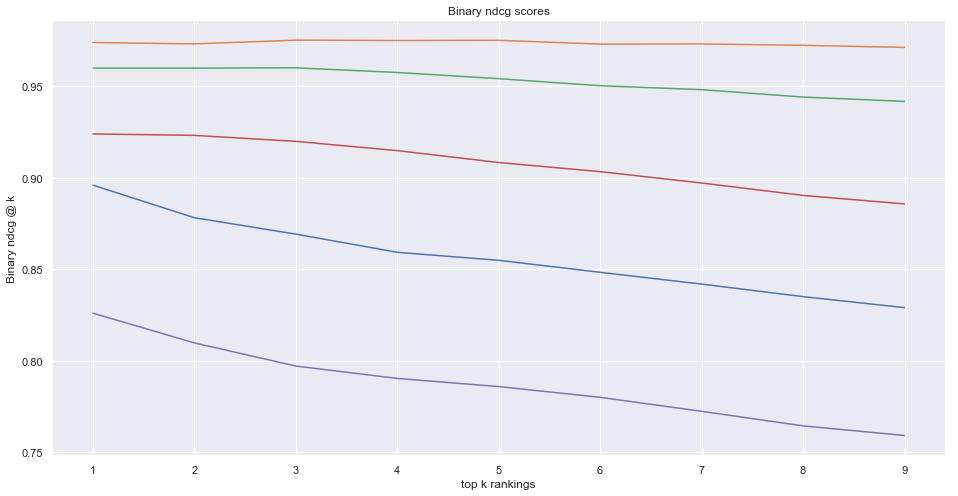

,kmeans++,affinity_propagation,agglomerative_l,agglomerative_m,agglomerative_s,agglomerative_t
0,0.896000,0.764000,0.974000,0.960000,0.924000,0.826000
1,0.878205,0.733825,0.973226,0.960000,0.923226,0.809752
2,0.869240,0.722090,0.975285,0.960144,0.919941,0.797095
3,0.859280,0.709393,0.975069,0.957612,0.914890,0.790330
4,0.854914,0.701582,0.975191,0.954223,0.908376,0.785874
5,0.848348,0.696131,0.973122,0.950356,0.903387,0.780003
6,0.841902,0.688286,0.973203,0.948214,0.897168,0.772344
7,0.835048,0.680671,0.972469,0.944159,0.890405,0.764383
8,0.829030,0.674798,0.971303,0.941800,0.885735,0.759129


In [807]:
X = range(1,10)

plt.figure(figsize=(16,8))

for Y in cluster_names:
    if Y=='affinity_propagation': pass
    else:
        sns.lineplot(y=Y,x=X,data=data[0][1],legend='full'
                        ).set(xlabel='top k rankings'
                             ,ylabel='Binary ndcg @ k'
                             ,title='Binary ndcg scores')

plt.show()

data[0][1]